In [1]:
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration
import torch
from PIL import Image
import requests
from transformers import AutoProcessor, LlavaForConditionalGeneration
import os
import matplotlib.pyplot as plt
import re
import json
import random

In [2]:
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)         # Should show '12.4' or your installed CUDA version


True
12.4


### Load image

In [3]:
# Load the local image
image_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/samples/step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square.png"
#print(os.path.exists(image_path))
image = Image.open(image_path)

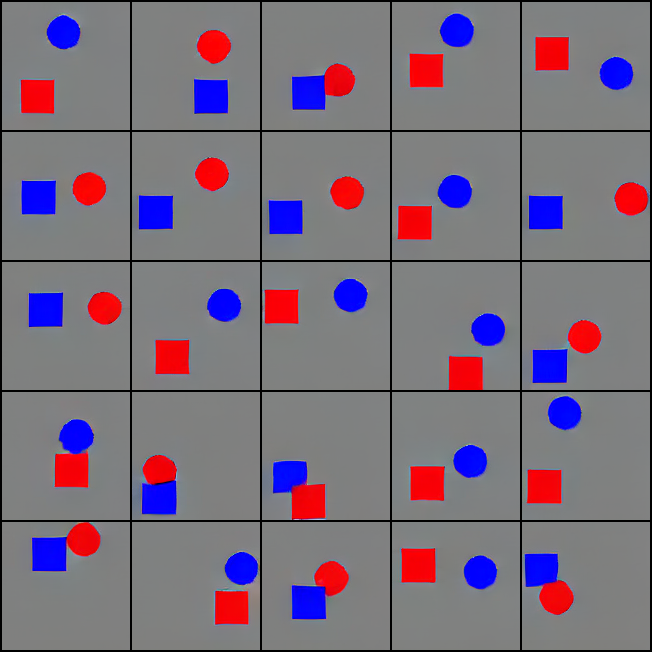

In [4]:
image

In [ ]:
def split_image_into_grid(image, grid_size=5, cell_size=128, padding=2):
    """
    Split an image into a grid of subimages.
    
    Args:
        image: PIL Image to split
        grid_size: Size of grid (grid_size x grid_size)
        cell_size: Width/height of each cell in pixels
        padding: Padding between cells in pixels
        
    Returns:
        List of subimages as PIL Images
    """
    width, height = image.size
    cell_width = cell_size
    cell_height = cell_size
    
    # Verify image dimensions match expected grid
    assert (cell_width + padding) * grid_size + padding == width and \
        (cell_height + padding) * grid_size + padding == height
        
    subimages = []
    for row in range(grid_size):
        for col in range(grid_size):
            left = col * (cell_width + padding) + padding
            upper = row * (cell_height + padding) + padding
            right = left + cell_width
            lower = upper + cell_height
            subimages.append(image.crop((left, upper, right, lower)))
            
    return subimages


In [5]:
# spliting into individual grid
# Define grid size (assuming 5x5 grid here)
grid_size = 5
width, height = image.size
cell_width = width // grid_size
cell_height = height // grid_size

# Split into subimages
subimages = []
for row in range(grid_size):
    for col in range(grid_size):
        left = col * cell_width
        upper = row * cell_height
        right = left + cell_width
        lower = upper + cell_height
        subimages.append(image.crop((left, upper, right, lower)))

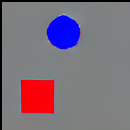

In [6]:
subimages[0]

### Process caption

In [7]:
filename = "step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square.png"

def extract_object_info(filename):
    """
    Extracts object information from a filename and returns it as a dictionary.

    Args:
    - filename (str): The filename containing object and relationship information.

    Returns:
    - dict: A dictionary with extracted object information.
    """
    # Regular expression to match the pattern in the filename
    pattern = r"sample_(\w+)_([\w_]+)_is_(\w+)_and_(\w+)_of_(\w+)_(\w+).png"
    match = re.search(pattern, filename)
    
    if match:
        # Extract values based on regex groups
        color_1 = match.group(1)
        shape_1 = match.group(2)
        spatial_relationship = f"{match.group(3)}_and_{match.group(4)}"
        color_2 = match.group(5)
        shape_2 = match.group(6)

        # Return as dictionary
        return {
            "shape_1": shape_1,
            "shape_2": shape_2,
            "color_1": color_1,
            "color_2": color_2,
            "spatial_relationship": spatial_relationship
        }
    else:
        raise ValueError("Filename does not match the expected pattern.")

# Example usage
filename = "step_100000_sample_blue_circle_is_above_and_to_the_right_of_blue_square.png"
object_info = extract_object_info(filename)
object_info


{'shape_1': 'circle',
 'shape_2': 'square',
 'color_1': 'blue',
 'color_2': 'blue',
 'spatial_relationship': 'above_and_to_the_right'}

### Load model

In [8]:
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")

model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
model.to("cuda:0")


# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image") 
conversation = [
    {

      "role": "user",
      "content": [
          {"type": "text", "text": "What is shown in this image?"},
          {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")

# autoregressively complete prompt
output = model.generate(**inputs, max_new_tokens=100)

print(processor.decode(output[0], skip_special_tokens=True))

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Expanding inputs for image tokens in LLaVa-NeXT should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


[INST]  
What is shown in this image? [/INST] The image shows a 4x4 grid with squares that are colored red, blue, and gray. Each square is either red, blue, or gray, and there are no squares that are adjacent to each other. The squares are arranged in a way that no two squares of the same color are adjacent to each other. This type of arrangement is known as a "non-adjacent magic square." 


### Construct base questions 

In [ ]:
# Initialize your model and processor (assuming LLAVA is being used)
#processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
#model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf", torch_dtype=torch.float16, low_cpu_mem_usage=True) 
#model.to("cuda:0")
# caption guided VQA: "The red triangle is diagonally up and left from the square,"
# Sample questions dictionary with structure for JSON saving
questions_data = {
    # shape count
    "1": {
        "question": "How many shapes are present in the image?",
        "options": ["A. 0", "B. 1", "C. 2", "D. equal to or more than 3"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None
    },
    "2": {
        "question": "How many blobs are present in the image?",
        "options": ["A. 0", "B. 1", "C. 2", "D. equal to or more than 3"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None
    },
    "3": {
        "question": "Are there exactly two distinct shapes in the image?",
        "options": ["A. Yes", "B. No", "C. Not sure"],
        "instructions": "\n Answer only in A, B or C.",
        "reference_answer": "A",
        "model_answer": None,
        "score": None
    },
    # shape types
    "4": {
        "question": "What is the shape that is red in color?",
        "options": ["A. Circle", "B. Square", "C. Triangle", "D. Unidentifiable", "E. No red color shapes"],
        "instructions": "\n Answer only in A, B, C, D or E.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0" 
    },
    "5": {
        "question": "What is the shape that is blue in color?",
        "options": ["A. Circle", "B. Square", "C. Triangle", "D. Unidentifiable", "E. No blue color shapes"],
        "instructions": "\n Answer only in A, B, C, D or E.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    # color types 
    "6": {
        "question": "What color is the square in the image?",
        "options": ["A. Red", "B. Blue", "C. Not red or blue", "D. No square shape"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    "7": {
        "question": "What color is the circle in the image?",
        "options": ["A. Red", "B. Blue", "C. Not red or blue", "D. No circle shape"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "D",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    "8": {
        "question": "What color is the triangle in the image?",
        "options": ["A. Red", "B. Blue", "C. Not red or blue", "D. No triangle shape"],
        "instructions": "\n Answer only in A, B, C or D.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "shapes question cannot be 0"
    },
    # spatial relations
    "9": {
        "question": "What's the spatial relationship between 2 blobs?",
        "options": ["A. Directly above vs. below", "B. Directly left vs. right", "C. Upper-left vs. Lower-right", "D. Upper-right vs. Lower-left", "E. Overlapping"],
        "instructions": "\n Answer only in A, B, C, D or E.",
        "reference_answer": "C",
        "model_answer": None,
        "score": None,
        "condition": "shapes question = 2"
    },
    "10": {
        "question": "Where is the red triangle relative to the square?",
        "options": ["A. Up and to the right", "B. Up and to the left", "C. Down and to the right", "D. Down and to the left", "E. Directly above", "F. Directly below", "G. Directly right", "H. Directly left", "I. Overlapping", "J. No triangle identified", "K. No square identified"],
        "instructions": "\n Answer only in A, B, C, D, E, F, G, H or I.",
        "reference_answer": "B",
        "model_answer": None,
        "score": None,
        "condition": "correctly respond to above questions"
    },
}

# Save initial questions data to a JSON file
with open("questions.json", "w") as f:
    json.dump(questions_data, f, indent=4)


### Update questions based on specific prompt

In [ ]:
def update_color_questions(question_data, object_info, target_color):
    """
    Update the reference answer for a question based on the presence of a specific color in the object info.

    Args:
    - question_data (dict): The question data dictionary to modify.
    - object_info (dict): Dictionary containing extracted object information.
    - target_color (str): The target color to check (e.g., 'red', 'blue').

    Returns:
    - None: Modifies question_data in place.
    """
    # Extract shapes and colors from object_info
    color_1 = object_info.get("color_1", "")
    shape_1 = object_info.get("shape_1", "")
    color_2 = object_info.get("color_2", "")
    shape_2 = object_info.get("shape_2", "")

    # Shape to option mapping
    shape_to_option = {
        "circle": "A",
        "square": "B",
        "triangle": "C",
        "unidentifiable": "D"
    }

    # Check for the presence of the target color
    if color_1 == target_color:
        question_data["reference_answer"] = shape_to_option.get(shape_1, "D")
    elif color_2 == target_color:
        question_data["reference_answer"] = shape_to_option.get(shape_2, "D")
    else:
        # Update the reference_answer to E (no shapes with the target color)
        question_data["reference_answer"] = "E"

def update_shape_questions(question_data, object_info, target_shape):
    """
    Update the reference answer for a question based on the target shape's color in the object info.

    Args:
    - question_data (dict): The question data dictionary to modify.
    - object_info (dict): Dictionary containing extracted object information.
    - target_shape (str): The target shape to check (e.g., 'circle', 'square').

    Returns:
    - None: Modifies question_data in place.
    """
    # Extract shapes and colors from object_info
    shape_1 = object_info.get("shape_1", "")
    color_1 = object_info.get("color_1", "")
    shape_2 = object_info.get("shape_2", "")
    color_2 = object_info.get("color_2", "")

    # Check which shape matches the target shape and assign the color
    if shape_1 == target_shape:
        if color_1 == "red":
            question_data["reference_answer"] = "A"  # Red
        elif color_1 == "blue":
            question_data["reference_answer"] = "B"  # Blue
        else:
            question_data["reference_answer"] = "C"  # Not red or blue
    elif shape_2 == target_shape:
        if color_2 == "red":
            question_data["reference_answer"] = "A"  # Red
        elif color_2 == "blue":
            question_data["reference_answer"] = "B"  # Blue
        else:
            question_data["reference_answer"] = "C"  # Not red or blue
    else:
        # No matching shape found
        question_data["reference_answer"] = "D"  # No such shape

# TODO: update relationship questions 


def modify_questions(json_path, object_info):
    """
    Modify the questions_data loaded from a JSON file based on object_info.

    Args:
    - json_path (str): Path to the JSON file containing question details.
    - object_info (dict): Dictionary containing extracted object information.

    Returns:
    - dict: Modified questions_data dictionary.
    """
    # Load the questions data from the JSON file
    with open(json_path, 'r') as file:
        questions_data = json.load(file)

    # Iterate through the questions to modify as needed
    for question_id, question_data in questions_data.items():
        if question_id == "4":  # Modify question 4 based on red shapes
            update_color_questions(question_data, object_info, target_color="red")
        if question_id == "5":  # Modify question 5 based on blue shapes
            update_color_questions(question_data, object_info, target_color="blue")
        if question_id == "6":  # Modify question 5 based on blue shapes
            update_shape_questions(question_data, object_info, target_shape="square")
        if question_id == "7":  # Modify question 5 based on blue shapes
            update_shape_questions(question_data, object_info, target_shape="circle")
        if question_id == "8":  # Modify question 5 based on blue shapes
            update_shape_questions(question_data, object_info, target_shape="triangle")
    with open(json_path, 'w') as file:
        json.dump(questions_data, file, indent=4)
    return questions_data


# Path to the JSON file containing question data
json_path = "questions.json"

# Modify the questions data
try:
    modified_questions = modify_questions(json_path, object_info)
except FileNotFoundError:
    print("The specified JSON file was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


In [13]:
# Load and prompt the model with questions, update answers and scores
def ask_model_and_update_json(processor, image, store_path="", file_path="questions.json"):
    # Load questions from JSON
    with open(file_path, "r") as f:
        questions = json.load(f)

    # Iterate over each question and prompt the model
    for q_id, q_data in questions.items():
        question_text = q_data["question"]
        options = q_data["options"]
        instructions = q_data["instructions"]
        reference_answer = q_data["reference_answer"]
        text_input = f"{question_text} Options: {', '.join(options)} {instructions}"
        #print(text_input)
        conversation = [
            {

            "role": "user",
            "content": [
                {"type": "text", "text": text_input},
                {"type": "image"},
                ],
            },
        ]
        # Format the question as a prompt for the model
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

        # Assume we have an image tensor prepared for inference
        # Replace 'image' below with the actual image tensor
        inputs = processor(images=image, text=prompt, return_tensors="pt").to("cuda:0")
        
        # Generate model's answer
        output = model.generate(**inputs, max_new_tokens=50, pad_token_id=processor.tokenizer.pad_token_id)
        decoded_output = processor.decode(output[0], skip_special_tokens=True)
        # Extract only the answer by splitting on "[INST]" and taking the last non-empty part
        model_answer = decoded_output.split("[INST]")[-1].strip()

        # If the answer includes extra spaces or text, you can further clean it up
        model_answer = model_answer.split()[-1]  # This assumes the answer is a single letter like "A", "B", "C", or "D"
        
        # Compare model answer to reference answer
        score = 1 if model_answer.strip() == reference_answer else 0
        
        # Update the question data with model answer and score
        questions[q_id]["model_answer"] = model_answer
        questions[q_id]["score"] = score

    # Save updated questions with answers and scores back to JSON
    with open(store_path, "w") as f:
        json.dump(questions, f, indent=4)




In [ ]:
base_store = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot/vqa/"

for i, subimage in enumerate(subimages):
    # Extract the unique identifier from the subimage path
    unique_name = os.path.basename(image_path).replace(".png", "")
    
    # Create a new folder under base_store with the unique name
    new_folder_path = os.path.join(base_store, unique_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Construct the specific JSON store path for the subimage
    store_path = os.path.join(new_folder_path, f"vqa_{i}.json")
    
    # Assuming `processor` is predefined, and `ask_model_and_update_json` requires the processor, image, and store path
    ask_model_and_update_json(processor, subimage, store_path)


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Settin

### Examine VQA response

In [15]:
subimage_id = 0
with open(f"{base_store}vqa_{subimage_id}.json", "r") as f:
    vqa = json.load(f)

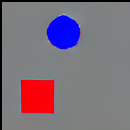

In [17]:
subimages[subimage_id]

In [16]:
vqa

{'1': {'question': 'How many shapes are present in the image?',
  'options': ['A. 0', 'B. 1', 'C. 2', 'D. equal to or more than 3'],
  'instructions': '\n Answer only in A, B, C or D.',
  'reference_answer': 'C',
  'model_answer': 'C',
  'score': 1},
 '2': {'question': 'How many blobs are present in the image?',
  'options': ['A. 0', 'B. 1', 'C. 2', 'D. equal to or more than 3'],
  'instructions': '\n Answer only in A, B, C or D.',
  'reference_answer': 'C',
  'model_answer': 'C',
  'score': 1},
 '3': {'question': 'Are there exactly two distinct shapes in the image?',
  'options': ['A. Yes', 'B. No', 'C. Not sure'],
  'instructions': '\n Answer only in A, B or C.',
  'reference_answer': 'A',
  'model_answer': 'B',
  'score': 0},
 '4': {'question': 'What is the shape that is red in color?',
  'options': ['A. Circle',
   'B. Square',
   'C. Triangle',
   'D. Unidentifiable',
   'E. No red color shapes'],
  'instructions': '\n Answer only in A, B, C, D or E.',
  'reference_answer': 'E',
 

### Other models

In [ ]:
# Specify the model ID; replace with the desired LLaVA model variant
model_id = "llava-hf/llava-1.5-7b-hf"

# Load the processor and model
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, torch_dtype=torch.float16)
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Load an image from a URL or local path
image_path = "example_QA.jpg"
image = Image.open(image_path)

# Define the text prompt
text_prompt = "Describe the content of the image."

# Prepare the input
inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(model.device)

# Generate a response
with torch.no_grad():
    outputs = model.generate(**inputs, max_new_tokens=50)

# Decode and print the response
response = processor.batch_decode(outputs, skip_special_tokens=True)[0]
print(response)